# Multimodal audio+image pipeline

This notebook contains a reorganized, split version of the original monolithic pipeline.
Cells are grouped by purpose (settings, extraction, audio cleaning, dataset, model, training, tests).
Keep this structure for easier refactoring, commenting and testing.

In [47]:
# Libraries
import os, glob, subprocess

import math, random
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import torch
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms, models

import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as AF

import soundfile as sf
import librosa

from sklearn.manifold import TSNE
from collections import Counter


In [ ]:
# SETTINGS
RAW_VIDEOS   = ""     # input videos
AUDIO_DIR    = "/scratch/zhanxiao_root/zhanxiao0/ppaiva/Dataset/audio_segments_10m"   # output 2s wavs
IMAGE_DIR    = "/scratch/zhanxiao_root/zhanxiao0/ppaiva/Dataset/cropped_frames_10m"  # output frame jpgs
SPECT_DIR    = "/scratch/zhanxiao_root/zhanxiao0/ppaiva/Dataset/fft_spec_arrays_10m"
MEL_DIR      = "/scratch/zhanxiao_root/zhanxiao0/ppaiva/Dataset/mel_spec_arrays_10m"


SAMPLE_RATE  = 48000
CHUNK_SECONDS= 2
BATCH_SIZE   = 20
EPOCHS       = 15
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
# Print device info to confirm CUDA availability and details
print('Torch CUDA available:', torch.cuda.is_available())
print('Using device:', DEVICE)
if torch.cuda.is_available():
    try:
        print('CUDA device count:', torch.cuda.device_count())
        if torch.cuda.device_count() > 0:
            try:
                cur = torch.cuda.current_device()
                print('CUDA current device index:', cur)
                print('CUDA device name:', torch.cuda.get_device_name(cur))
            except Exception as e:
                print('Could not query CUDA device name:', e)
    except Exception as e:
        print('CUDA query error:', e)

label_map = {"0p_10m": 0, "50p_10m": 1, "100p_10m": 2}
LABELS = {v: k.capitalize() for k, v in label_map.items()}

os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(MEL_DIR, exist_ok=True)

# Audio / STFT / Mel constants
NFFT = 2048
HOP = 512
N_MELS = 128
# Ultrasonic attention range (Hz) per your request: 15k-20k
BAND_LO = 15000
BAND_HI = 20000


Torch CUDA available: True
Using device: cuda
CUDA device count: 1
CUDA current device index: 0
CUDA device name: NVIDIA A40


In [49]:
# IMAGE TRANSFORM and audio cleaning constants
gray = transforms.Grayscale(num_output_channels=3)
transform_image = transforms.Compose([
    transforms.Resize((224,224)),
    gray,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# # Audio cleaning for a 2s chunk (band-pass + quiet-frame spectral subtraction)
# SR        = SAMPLE_RATE
# BAND_LO   = 12000
# BAND_HI   = 18000
# NFFT      = 2048
# HOP       = 512
# OVERSUB   = 1.2
# QUIET_PCT = 0.20

# def _stft(x: torch.Tensor) -> torch.Tensor:
#     if x.dim() == 2: x = x.squeeze(0)
#     return torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
#                       window=torch.hann_window(NFFT), return_complex=True, center=True)

# def _istft(S: torch.Tensor, length: int) -> torch.Tensor:
#     win = torch.hann_window(NFFT, device=S.device, dtype=torch.float32)
#     try:
#         y = torch.istft(S, n_fft=NFFT, hop_length=HOP, win_length=NFFT, window=win, length=length, center=True)
#     except (TypeError, RuntimeError):
#         y = torch.istft(torch.view_as_real(S), n_fft=NFFT, hop_length=HOP, win_length=NFFT, window=win, length=length, center=True)
#     return y

# def bandpass_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
#     if waveform.dim() == 1:
#         waveform = waveform.unsqueeze(0)
#     x = waveform.squeeze(0).to(torch.float32)
#     S = torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT, window=torch.hann_window(NFFT, dtype=torch.float32), return_complex=True, center=True)
#     freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
#     lo = int(np.searchsorted(freqs, BAND_LO))
#     hi = int(np.searchsorted(freqs, BAND_HI))
#     lo = max(lo, 0); hi = min(hi, S.shape[0])
#     mask = torch.zeros_like(S, dtype=torch.bool)
#     mask[lo:hi, :] = True
#     S_bp = torch.where(mask, S, torch.zeros_like(S))
#     y = _istft(S_bp, length=x.numel())
#     y = y - y.mean()
#     y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
#     return y.unsqueeze(0)

# def spectral_subtract_quiet_frames(waveform: torch.Tensor, sr: int) -> torch.Tensor:
#     x = waveform.squeeze(0)
#     Tlen = x.shape[-1]
#     S = _stft(x)
#     Mag = S.abs()
#     Pow = Mag**2
#     freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
#     lo = int(np.searchsorted(freqs, BAND_LO))
#     hi = int(np.searchsorted(freqs, BAND_HI))
#     lo = max(lo, 0); hi = min(hi, Mag.shape[0])
#     band_pow_per_frame = Pow[lo:hi].mean(dim=0)
#     T_frames = band_pow_per_frame.numel()
#     k = max(1, int(round(QUIET_PCT * T_frames)))
#     vals, idxs = torch.topk(-band_pow_per_frame, k)
#     quiet_mask = torch.zeros_like(band_pow_per_frame, dtype=torch.bool)
#     quiet_mask[idxs] = True
#     Npsd = Pow[:, quiet_mask].mean(dim=1, keepdim=True)
#     Pclean = torch.clamp(Pow - OVERSUB * Npsd, min=0.0)
#     Mag_clean = torch.sqrt(Pclean + 1e-12)
#     S_clean = Mag_clean * torch.exp(1j * S.angle())
#     y_clean = _istft(S_clean, length=Tlen)
#     y_clean = y_clean - y_clean.mean()
#     y_clean = torch.nan_to_num(y_clean, nan=0.0, posinf=0.0, neginf=0.0)
#     return y_clean.unsqueeze(0)

# def clean_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
#     if waveform.dim() == 2 and waveform.shape[0] > 1:
#         waveform = waveform.mean(dim=0, keepdim=True)
#     elif waveform.dim() == 1:
#         waveform = waveform.unsqueeze(0)
#     if sr != SR:
#         waveform = torchaudio.functional.resample(waveform, sr, SR)
#         sr = SR
#     y_bp = bandpass_chunk(waveform, sr)
#     y_cl = spectral_subtract_quiet_frames(y_bp, sr)
#     return y_cl

In [ ]:
class AudioImageDataset(Dataset):
    def __init__(self, audio_dir, spect_dir, image_dir, label_map, transform_image=None):
        self.audio_dir = audio_dir
        self.spect_dir = spect_dir
        self.image_dir = image_dir
        self.label_map = label_map
        self.transform_image = transform_image

        self.npy_files = []
        self.labels = []
        self.seg_ids = []

        # ----- PAIR VIDEO FRAME AND FFT AUDIO ARRAY -----
        # Find all .npy spectrogram files
        for file in os.listdir(spect_dir):
            if file.endswith(".npy"):
                # EXTRACT LABEL FROM FILENAME
                base = file.split("_seg")[0].lower()
                if base in label_map:
                    self.npy_files.append(file)
                    self.labels.append(label_map[base])
                    self.seg_ids.append(file)

        print(f"Loaded {len(self.npy_files)} spectrograms from {spect_dir}")

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        npy_file = self.npy_files[idx]
        label    = self.labels[idx]
        seg_id   = self.seg_ids[idx]
    
        # ----- LOAD PRECOMPUTED S_ultra -----
        path = os.path.join(self.spect_dir, npy_file)
        S_ultra = np.load(path).astype(np.float32)   # shape (freq_bins, time_frames)
    
        # ============================================================
        # 1) FIX TIME-DIMENSION MISMATCH (PAD OR CROP TO FIXED WIDTH)
        # ============================================================
        target_W = 400   # Choose the width you want all spectrograms to have
    
        F, W = S_ultra.shape
    
        if W < target_W:
            pad = target_W - W
            S_ultra = np.pad(S_ultra, ((0, 0), (0, pad)), mode='constant')
        elif W > target_W:
            S_ultra = S_ultra[:, :target_W]
        # ============================================================
    
        # ----- NORMALIZE (after fixing shape) -----
        S_ultra = (S_ultra - S_ultra.mean()) / (S_ultra.std() + 1e-6)
    
        # ----- TO TENSOR -----
        audio_tensor = torch.tensor(S_ultra).unsqueeze(0)   # shape (1, F, T)

        # ----- LOAD OR COMPUTE MEL SPECTROGRAM -----
        mel_file = npy_file.replace(".npy", "_mel.npy")
        mel_path = os.path.join(self.image_dir.replace('cropped_frames', 'mel_spec_arrays') if 'cropped_frames' in self.image_dir else os.path.join(os.path.dirname(self.spect_dir), '..', 'mel_spec_arrays'), mel_file)
        # Preferred location: MEL_DIR (from settings); fall back to same folder
        try:
            mel_path = os.path.join(MEL_DIR, mel_file)
        except NameError:
            mel_path = os.path.join(os.path.dirname(self.spect_dir), mel_file)

        if os.path.exists(mel_path):
            S_mel = np.load(mel_path).astype(np.float32)
        else:
            # Try to compute mel from corresponding WAV file if available
            wav_file = npy_file.replace('.npy', '.wav')
            wav_path = os.path.join(self.audio_dir, wav_file)
            if os.path.exists(wav_path):
                y, sr = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)
                S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=NFFT, hop_length=HOP, n_mels=N_MELS)
                S_mel = librosa.power_to_db(S_mel, ref=np.max).astype(np.float32)
                # Save for future runs
                try:
                    os.makedirs(MEL_DIR, exist_ok=True)
                    np.save(os.path.join(MEL_DIR, mel_file), S_mel)
                except Exception:
                    pass
            else:
                # If we cannot find or create mel, use a zero array with reasonable shape
                S_mel = np.zeros((N_MELS, S_ultra.shape[1]), dtype=np.float32)
    
        # ----- NORMALIZE MEL AND CONVERT TO TENSOR -----
        # Ensure mel has time-dim similar to target_W (pad or crop)
        Fm, Wm = S_mel.shape
        if Wm < target_W:
            pad = target_W - Wm
            S_mel = np.pad(S_mel, ((0, 0), (0, pad)), mode='constant')
        elif Wm > target_W:
            S_mel = S_mel[:, :target_W]

        S_mel = (S_mel - S_mel.mean()) / (S_mel.std() + 1e-6)
        mel_tensor = torch.tensor(S_mel).unsqueeze(0)  # (1, N_MELS, T)

        # ----- RESIZE SPECTROGRAMS TO 224x224 FOR RESNET INPUT -----
        # Use torch.nn.functional.interpolate which expects (B, C, H, W)
        audio_tensor = torch.nn.functional.interpolate(audio_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        mel_tensor = torch.nn.functional.interpolate(mel_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        # ----- LOAD MATCHING FRAME -----
        frame_file = npy_file.replace("seg", "frame").replace(".npy", ".jpg")
        img_path = os.path.join(self.image_dir, frame_file)
        img = Image.open(img_path).convert("RGB")
    
        if self.transform_image:
            img = self.transform_image(img)

        return audio_tensor, mel_tensor, img, label, seg_id


class AudioPreprocessor:
    """Precompute Mel spectrograms for existing audio chunks."""
    def __init__(self, audio_dir=AUDIO_DIR, mel_dir=MEL_DIR, sr=SAMPLE_RATE, n_fft=NFFT, hop=HOP, n_mels=N_MELS):
        self.audio_dir = audio_dir
        self.mel_dir = mel_dir
        self.sr = sr
        self.n_fft = n_fft
        self.hop = hop
        self.n_mels = n_mels
        os.makedirs(self.mel_dir, exist_ok=True)

    def compute_mel_for_wav(self, wav_path, out_path):
        try:
            y, sr = librosa.load(wav_path, sr=self.sr, mono=True)
            S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=self.n_fft, hop_length=self.hop, n_mels=self.n_mels)
            S_mel_db = librosa.power_to_db(S_mel, ref=np.max).astype(np.float32)
            np.save(out_path, S_mel_db)
            return out_path
        except Exception as e:
            print(f"Failed compute mel for {wav_path}: {e}")
            return None

    def precompute_for_spect_files(self, spect_dir=SPECT_DIR, audio_dir=AUDIO_DIR):
        files = [f for f in os.listdir(spect_dir) if f.endswith('.npy')]
        for f in files:
            mel_name = f.replace('.npy', '_mel.npy')
            out_path = os.path.join(self.mel_dir, mel_name)
            if os.path.exists(out_path):
                continue
            wav_name = f.replace('.npy', '.wav')
            wav_path = os.path.join(audio_dir, wav_name)
            if os.path.exists(wav_path):
                self.compute_mel_for_wav(wav_path, out_path)
            else:
                # try to compute from spectrogram if wav missing
                try:
                    S_ultra = np.load(os.path.join(spect_dir, f))
                    # approximate mel by applying librosa.feature.melspectrogram on reconstructed waveform is expensive; skip
                    # instead save a resized zero array to keep dataset consistent
                    S_mel_db = np.zeros((self.n_mels, S_ultra.shape[1]), dtype=np.float32)
                    np.save(out_path, S_mel_db)
                except Exception:
                    pass


In [51]:
def create_loaders(
    dataset,
    batch_size,
    train_frac=0.65,
    val_frac=0.34,
    test_frac=0.01,
    seed=42,
):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6, "Fractions must sum to 1.0"

    n = len(dataset)
    indices = list(range(n))

    random.seed(seed)
    random.shuffle(indices)

    n_train = int(n * train_frac)
    n_val   = int(n * val_frac)
    n_test  = n - n_train - n_val

    train_idx = indices[:n_train]
    val_idx   = indices[n_train:n_train + n_val]
    test_idx  = indices[n_train + n_val:]

    train_ds = Subset(dataset, train_idx)
    val_ds   = Subset(dataset, val_idx)
    test_ds  = Subset(dataset, test_idx)


    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    print(
        f"Train samples: {len(train_ds)}, "
        f"Val samples: {len(val_ds)}, "
        f"Test samples: {len(test_ds)}"
    )

    return train_loader, val_loader, test_loader


In [ ]:
class MultiModalResNet(nn.Module):
    def __init__(self, num_classes=3, pretrained_image=True, pretrained_audio=True):
        super().__init__()
        self.audio_model = models.resnet18(weights="IMAGENET1K_V1" if pretrained_audio else None)
        self.audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.audio_model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.audio_model.fc = nn.Identity()
        # Mel branch (same architecture as audio branch)
        self.mel_model = models.resnet18(weights="IMAGENET1K_V1" if pretrained_audio else None)
        self.mel_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mel_model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.mel_model.fc = nn.Identity()

        self.image_model = models.resnet18(weights="IMAGENET1K_V1" if pretrained_image else None)
        self.image_model.fc = nn.Identity()

        # Fusion: audio (512) + mel (512) + image (512)
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, audio, mel, image, return_features=False):
        # audio shape: (B, 1, 224, 224)
        # mel shape: (B, 1, 224, 224)
        # image shape: (B, 3, 224, 224)

        a = self.audio_model(audio)   # (B, 512)
        m = self.mel_model(mel)       # (B, 512)
        i = self.image_model(image)   # (B, 512)

        fused = torch.cat([a, m, i], dim=1)  # (B, 1536)
        out = self.fc(fused)                  # (B, num_classes)

        if return_features:
            return a, m, i, fused, out
        return out


In [ ]:
# FEATURE VISUALIZATION (t-SNE)
def visualize_features(model, dataloader, title_suffix=""):
    model.eval()
    audio_feats, image_feats, fused_feats, labels_all = [], [], [], []
    mel_feats = []

    with torch.no_grad():
        for audio, mel, img, labels, _ in dataloader:
            audio, mel, img, labels = audio.to(DEVICE), mel.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
            a, m, i, fused, _ = model(audio, mel, img, return_features=True)
            audio_feats.append(a.cpu())
            mel_feats.append(m.cpu())
            image_feats.append(i.cpu())
            fused_feats.append(fused.cpu())
            labels_all.append(labels.cpu())

    # Handle empty loader
    if len(audio_feats) == 0:
        print("[visualize_features] No samples in dataloader – skipping t-SNE.")
        return

    audio_feats = torch.cat(audio_feats).numpy()
    mel_feats = torch.cat(mel_feats).numpy()
    image_feats = torch.cat(image_feats).numpy()
    fused_feats = torch.cat(fused_feats).numpy()
    labels_all = torch.cat(labels_all).numpy()

    print("Label counts:", Counter(labels_all))

    n = fused_feats.shape[0]
    if n < 3:
        print(f"[visualize_features] Only {n} samples – too few for t-SNE. Skipping.")
        return

    # Perplexity must be < n and generally >= 5 for stable plots
    perpl = min(30, max(5, min(n - 1, n // 3)))

    tsne = TSNE(n_components=2, random_state=42, perplexity=perpl)
    A2 = tsne.fit_transform(audio_feats)
    M2 = tsne.fit_transform(mel_feats)
    I2 = tsne.fit_transform(image_feats)
    F2 = tsne.fit_transform(fused_feats)

    fig, axes = plt.subplots(1, 4, figsize=(22, 6))
    for data2d, name, ax in zip([A2, M2, I2, F2], ["Audio", "Mel", "Image", "Fused"], axes):
        for l in sorted(set(labels_all)):
            idx = labels_all == l
            ax.scatter(data2d[idx, 0], data2d[idx, 1], alpha=0.6, s=20, label=LABELS[l])
        ax.set_title(f"{name} Features {title_suffix}")
        ax.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_audio_preprocessing(dataset, idx=0, spect_dir=None):
    """
    Compare:
        1) Waveform
        2) Mel spectrogram (your old pipeline)
        3) Linear-frequency ultrasonic STFT (current pipeline)
    """

    # ------------------------
    # Identify audio + spectrogram files
    # ------------------------
    audio_file = dataset.npy_files[idx] \
        if hasattr(dataset, "npy_files") else dataset.audio_files[idx]

    label = dataset.labels[idx]

    # Original audio filename (convert npy -> wav)
    if audio_file.endswith(".npy"):
        wav_file = audio_file.replace(".npy", ".wav").replace("seg", "seg")
    else:
        wav_file = audio_file

    wav_path = os.path.join(dataset.audio_dir, wav_file)
    if not os.path.exists(wav_path):
        print("Could not locate original WAV:", wav_path)
        return

    # Load waveform
    audio_np, sr = sf.read(wav_path)
    if audio_np.ndim > 1:
        audio_np = audio_np[:,0]
    t = np.linspace(0, len(audio_np)/sr, len(audio_np))

    # ------------------------
    # Mel spectrogram
    # ------------------------
    mel_transform = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    wave = torch.tensor(audio_np, dtype=torch.float32)
    mel_db = T.AmplitudeToDB()(mel_transform(wave))

    mel_img = mel_db.numpy()

    # ------------------------
    # Linear STFT S_ultra (load from npy)
    # ------------------------
    if audio_file.endswith(".npy"):
        npy_path = os.path.join(spect_dir, audio_file)
        S_ultra = np.load(npy_path)
        # Try to load precomputed mel if available
        mel_path = os.path.join(MEL_DIR, audio_file.replace('.npy', '_mel.npy'))
        if os.path.exists(mel_path):
            mel_img = np.load(mel_path)
        else:
            mel_img = mel_img  # fall back to mel computed above
    else:
        print("Dataset does not use npy spectrograms. Skipping S_ultra visualization.")
        S_ultra = None

    # ------------------------
    # Plot everything
    # ------------------------
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))

    # 1. Raw waveform
    axes[0].plot(t, audio_np, linewidth=0.8)
    axes[0].set_title("Raw Waveform")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")

    # 2. Mel spectrogram
    im1 = axes[1].imshow(mel_img, aspect="auto", origin="lower", cmap="inferno")
    axes[1].set_title("Mel Spectrogram (Old Pipeline)")
    fig.colorbar(im1, ax=axes[1])

    # 3. Ultrasonic STFT
    if S_ultra is not None:
        im2 = axes[2].imshow(S_ultra, aspect="auto", origin="lower", cmap="inferno")
        axes[2].set_title("Ultrasonic STFT (New Pipeline)")
        fig.colorbar(im2, ax=axes[2])
    else:
        axes[2].text(0.5,0.5, "No STFT Available", ha="center", va="center")
        axes[2].set_title("Ultrasonic STFT")

    plt.suptitle(f"Preprocessing Comparison — Label: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:

# TRAINING
def train():
    dataset = AudioImageDataset(
        audio_dir = AUDIO_DIR,
        spect_dir=SPECT_DIR,
        image_dir=IMAGE_DIR,
        label_map=label_map,
        transform_image=transform_image
    )


    if len(dataset) == 0:
        print("[ERROR] No segments found. Did you run prepare_dataset_from_videos()?") 
        return
    
    rand_idx = random.randint(0, len(dataset) - 1)
    print(f"Visualizing sample idx={rand_idx}")
    visualize_audio_preprocessing(dataset, idx=rand_idx, spect_dir=SPECT_DIR)

    train_loader, val_loader, test_loader = create_loaders(dataset, batch_size=BATCH_SIZE)

    model = MultiModalResNet(num_classes=len(label_map)).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    print("Visualizing features BEFORE training...")
    visualize_features(model, val_loader, title_suffix="(Before)")

    for epoch in tqdm(range(EPOCHS)):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for audio, mel, img, labels, seg_ids in train_loader:
            # Dataset yields (audio, mel, img, label, seg_id)
            audio, mel, img, labels = audio.to(DEVICE), mel.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(audio, mel, img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_loss = running_loss / max(1, total)
        train_acc  = correct / max(1, total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_preds, val_labels, val_segids = [], [], []

        with torch.no_grad():
            for audio, mel, img, labels, seg_ids in val_loader:
                audio, mel, img, labels = audio.to(DEVICE), mel.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
                outputs = model(audio, mel, img)
                loss = criterion(outputs, labels)

                batch_size = labels.size(0)
                val_loss += loss.item() * batch_size
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total   += batch_size

                val_preds.extend(preds.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())
                val_segids.extend(seg_ids)

        val_loss /= max(1, val_total)
        val_acc   = val_correct / max(1, val_total)

        print(
            f"Epoch [{epoch+1}/{EPOCHS}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        visualize_features(model, val_loader, title_suffix=f"(Epoch {epoch+1})")

    print("Visualizing features AFTER training...")
    visualize_features(model, val_loader, title_suffix="(After)")
    return model, test_loader, criterion


In [ ]:
def evaluate(model, dataloader, criterion, device, split_name="Eval"):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad():
        for audio, mel, img, labels, seg_ids in dataloader:
            audio, mel, img, labels = audio.to(device), mel.to(device), img.to(device), labels.to(device)
            outputs = model(audio, mel, img)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            _, preds = outputs.max(1)
            total_correct += (preds == labels).sum().item()
            total_samples += batch_size

    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)

    print(f"{split_name} Loss: {avg_loss:.4f}, {split_name} Acc: {avg_acc:.4f} (n={total_samples})")
    return avg_loss, avg_acc, total_samples


def test(model, test_loader, criterion, device, visualize=True):
 
    if visualize:
        print("\nVisualizing test set features...")
        visualize_features(model, test_loader, title_suffix="(Test Set)")

    print("\nEvaluating on test set...")
    return evaluate(model, test_loader, criterion, device, split_name="Test")


In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Test Confusion Matrix")
    plt.show()



def plot_class_accuracy(y_true, y_pred, labels):

    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    # --- Normalize labels into a list of class names in index order ---
    if isinstance(labels, dict):
        num_classes = len(labels)
        class_names = [labels[i] for i in range(num_classes)]
    else:
        class_names = list(labels)
        num_classes = len(class_names)

    accuracies = []
    for cls in range(num_classes):
        idx = (y_true == cls)
        if idx.any():
            acc = (y_pred[idx] == cls).float().mean().item()
        else:
            acc = float("nan")  # or 0.0 if you prefer
        accuracies.append(acc)

    x = np.arange(num_classes)

    plt.figure(figsize=(8, 4))
    plt.bar(x, accuracies)
    plt.xticks(x, class_names)
    plt.ylabel("Accuracy")
    plt.title("Per-Class Test Accuracy")
    plt.ylim(0, 1)
    plt.show()



In [ ]:
def visualize_test_correctness(model, dataloader):
    model.eval()
    feats, correct_mask = [], []

    with torch.no_grad():
        for audio, mel, img, labels, _ in dataloader:
            audio, mel, img = audio.to(DEVICE), mel.to(DEVICE), img.to(DEVICE)
            a, m, i, fused, out = model(audio, mel, img, return_features=True)
            preds = out.argmax(dim=1).cpu()

            feats.append(fused.cpu())
            correct_mask.extend((preds == labels).cpu().tolist())

    feats = torch.cat(feats).numpy()
    correct_mask = np.array(correct_mask)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    Z = tsne.fit_transform(feats)

    plt.figure(figsize=(7,6))
    plt.scatter(Z[correct_mask,0], Z[correct_mask,1], s=20, color="green", label="Correct", alpha=0.6)
    plt.scatter(Z[~correct_mask,0], Z[~correct_mask,1], s=20, color="red", label="Wrong", alpha=0.6)
    plt.legend()
    plt.title("Test Embedding: Correct vs Wrong")
    plt.show()


In [1]:
def collect_preds_from_loader(model, dataloader, device):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for audio, mel, img, labels, seg_ids in dataloader:
            audio, mel, img = audio.to(device), mel.to(device), img.to(device)
            outputs = model(audio, mel, img)
            preds = outputs.argmax(dim=1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(labels.tolist())
    return y_true, y_pred


def debug_smoke_test():
    """Quick forward/backward pass with random tensors to validate shapes and training step."""
    model = MultiModalResNet(num_classes=len(label_map)).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    bs = 2
    audio = torch.randn(bs, 1, 224, 224).to(DEVICE)
    mel = torch.randn(bs, 1, 224, 224).to(DEVICE)
    img = torch.randn(bs, 3, 224, 224).to(DEVICE)
    labels = torch.randint(0, len(label_map), (bs,)).to(DEVICE)

    model.train()
    optimizer.zero_grad()
    outputs = model(audio, mel, img)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    print("Debug smoke test passed — loss:", loss.item())


Loaded 900 spectrograms from /scratch/zhanxiao_root/zhanxiao0/ppaiva/Dataset/fft_spec_arrays_10m
Visualizing sample idx=480


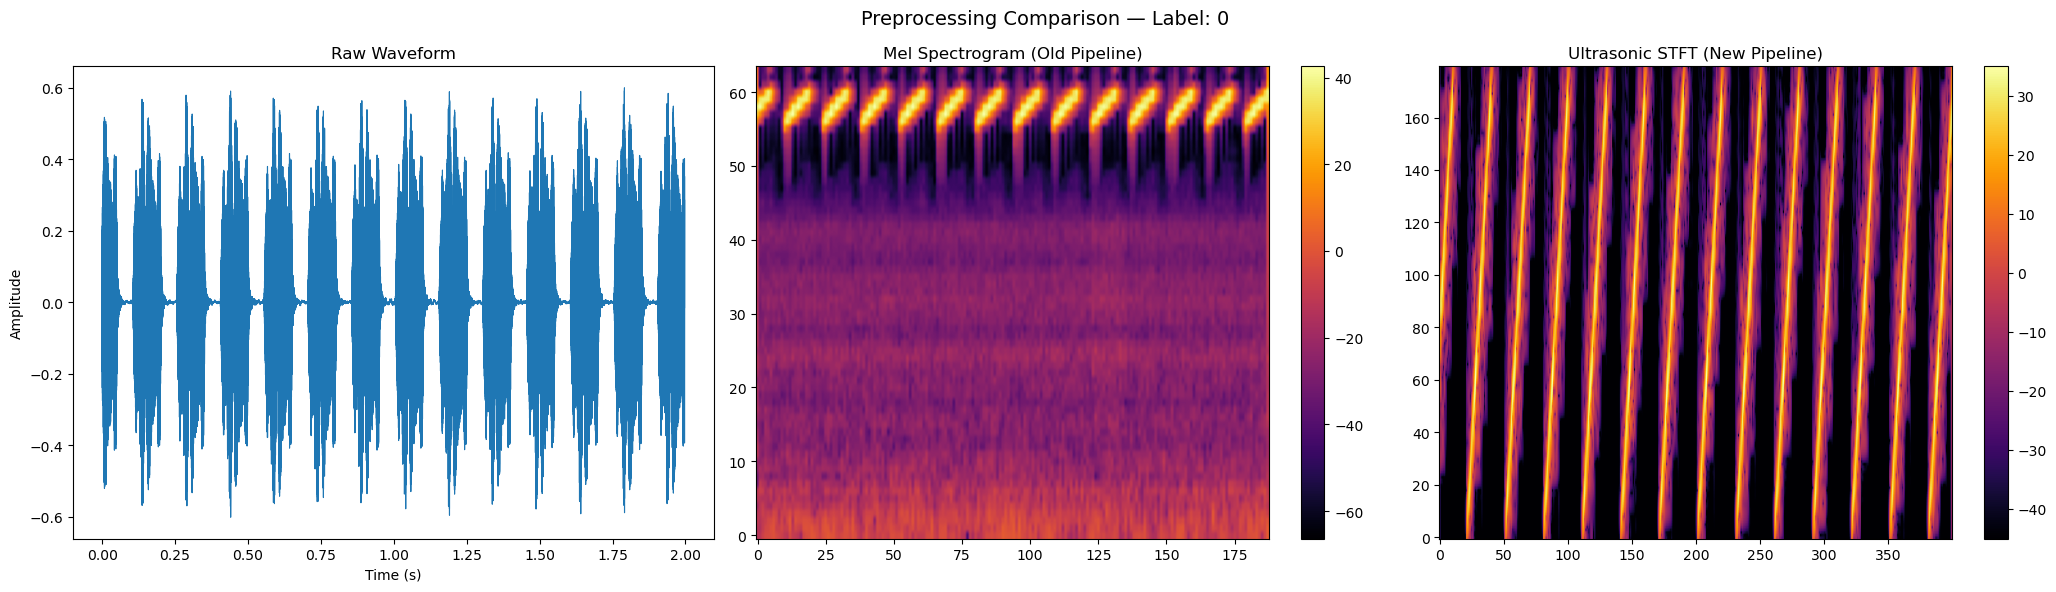

Train samples: 585, Val samples: 306, Test samples: 9
Visualizing features BEFORE training...


/home/ppaiva/.local/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1522110311c0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1522110337e0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

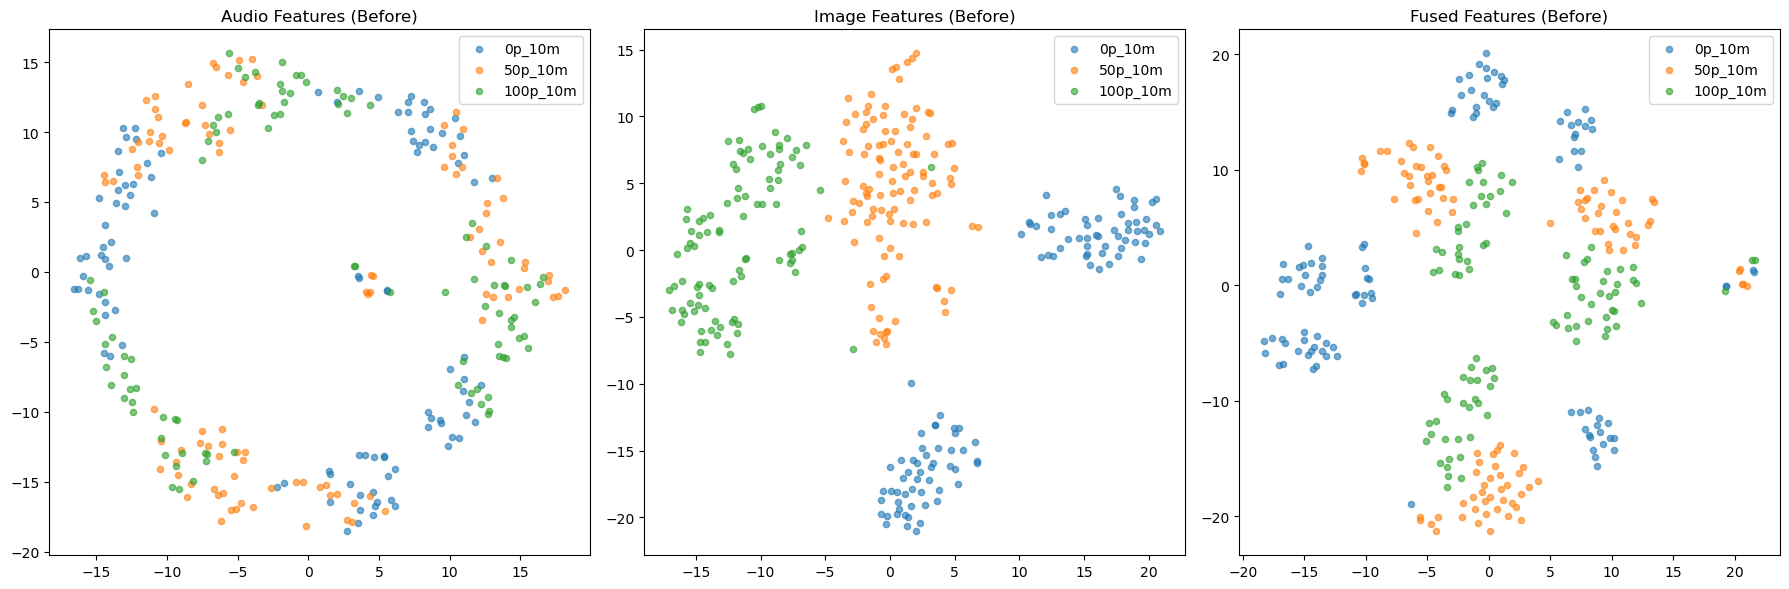

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15] Train Loss: 0.1756, Train Acc: 0.9419, Val Loss: 0.5872, Val Acc: 0.6373


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220d0ab420>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220d0a8540>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

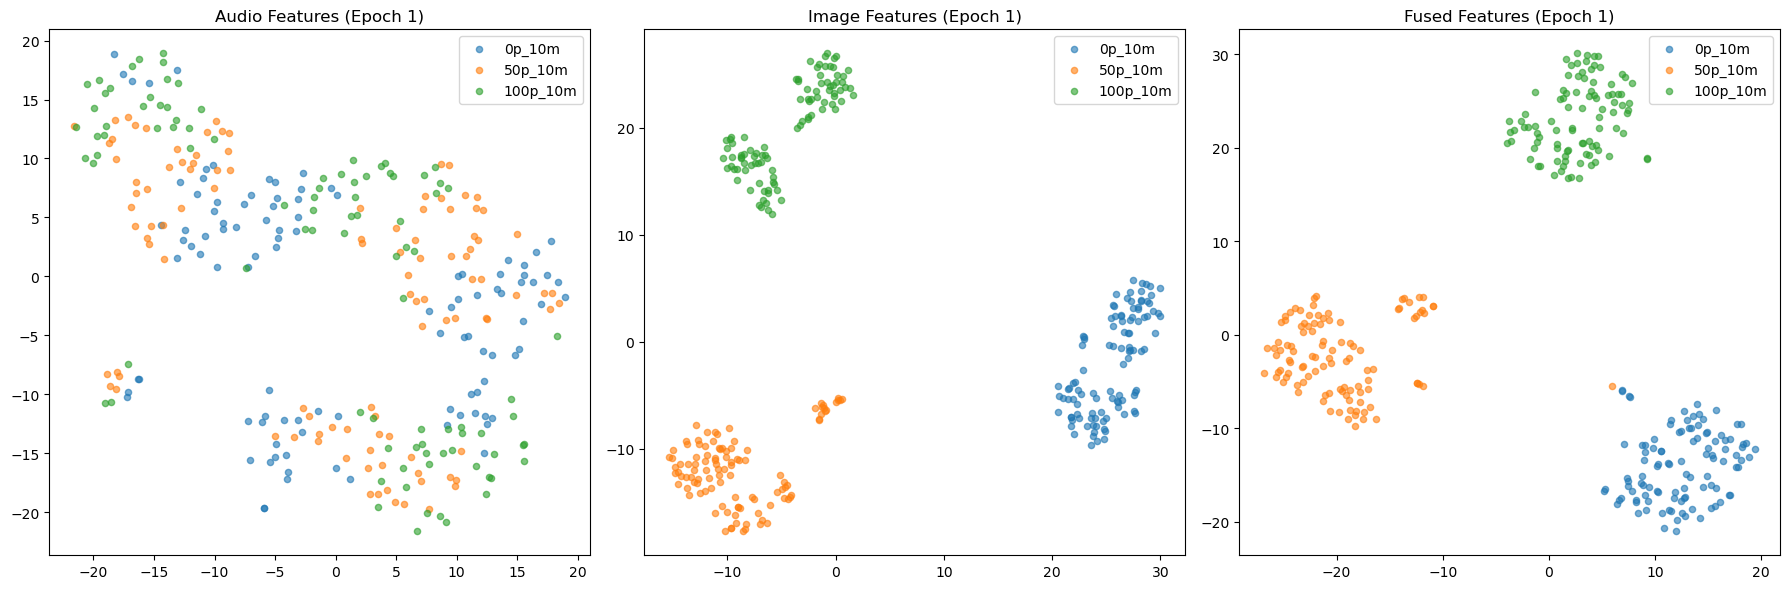

  7%|▋         | 1/15 [00:07<01:41,  7.27s/it]

Epoch [2/15] Train Loss: 0.0064, Train Acc: 1.0000, Val Loss: 0.0030, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220f732520>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220cffad40>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

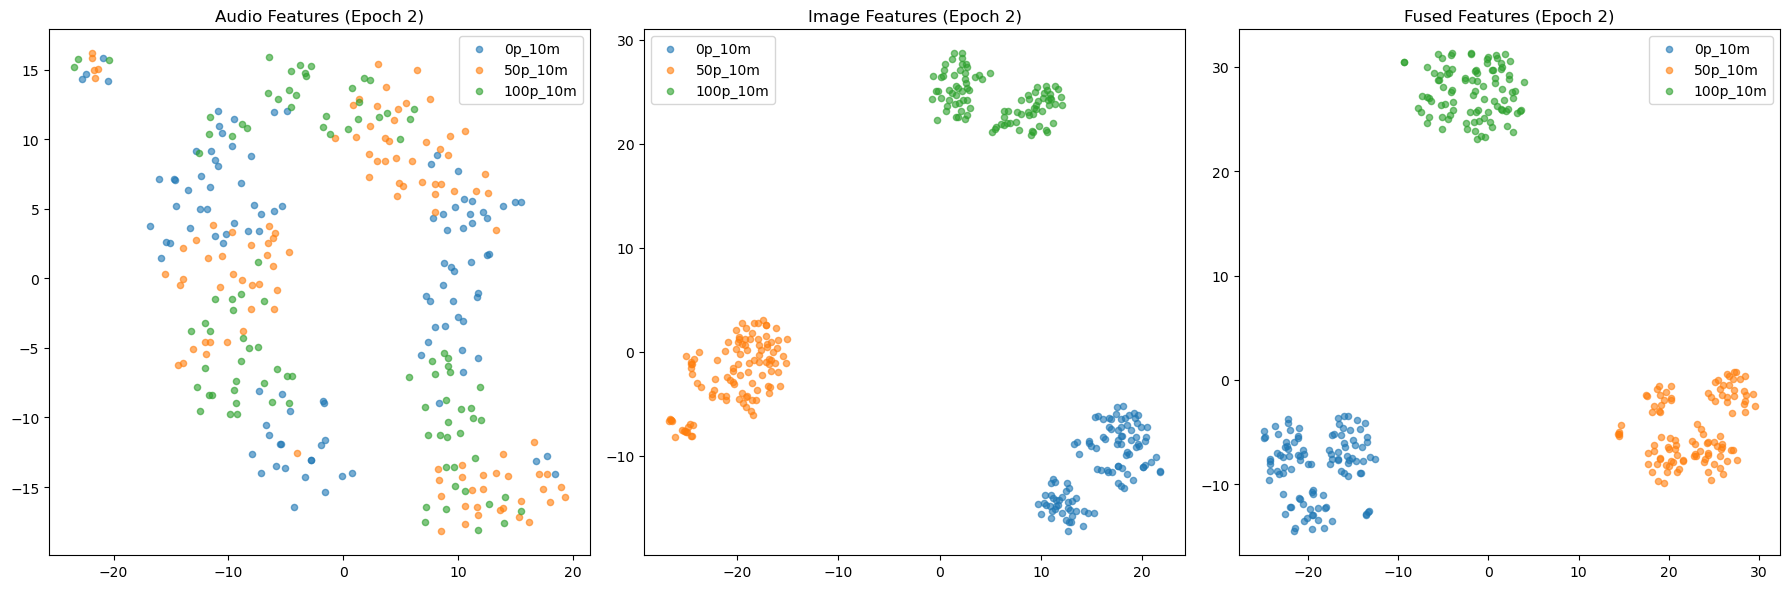

 13%|█▎        | 2/15 [00:14<01:37,  7.53s/it]

Epoch [3/15] Train Loss: 0.0020, Train Acc: 1.0000, Val Loss: 0.0007, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220c0cdf80>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220c0cdf80>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

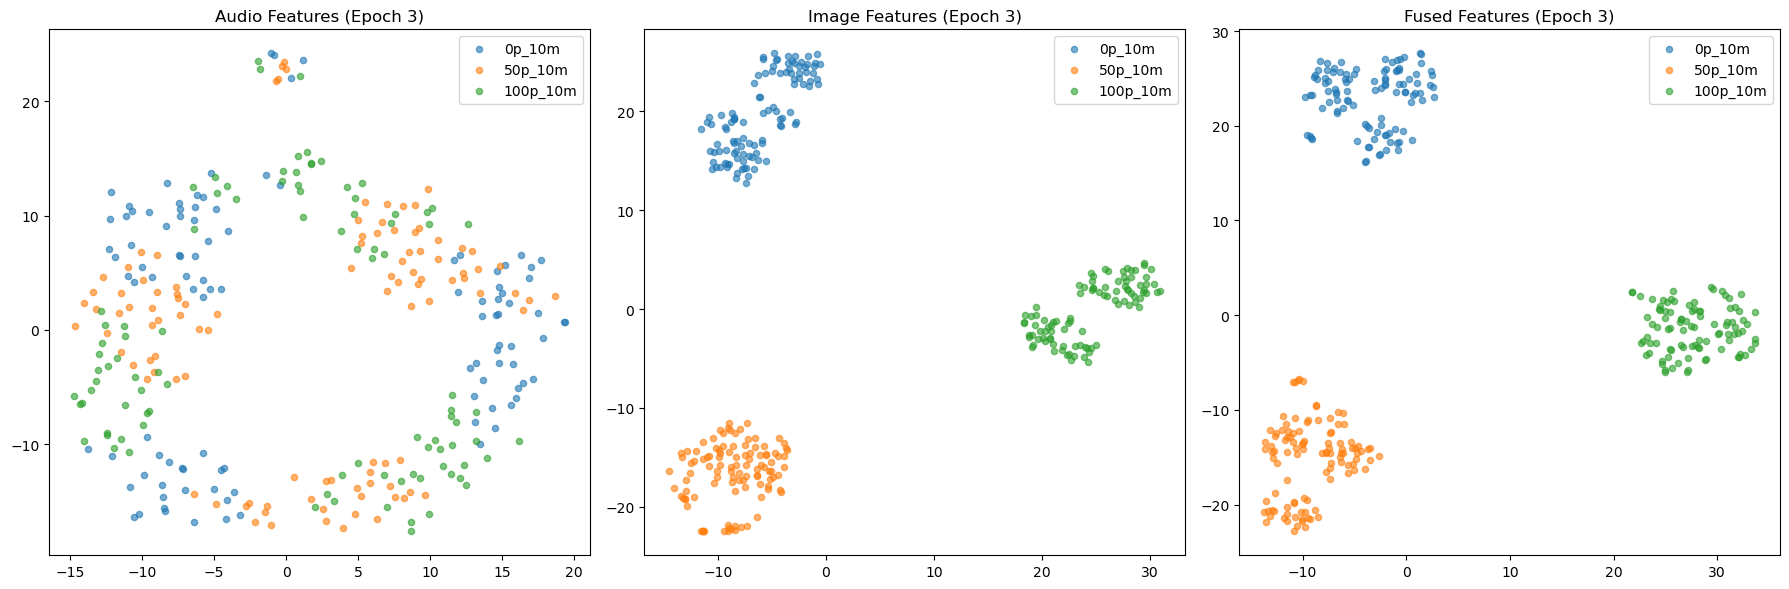

 20%|██        | 3/15 [00:22<01:28,  7.37s/it]

Epoch [4/15] Train Loss: 0.0015, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220481ba60>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220481b740>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

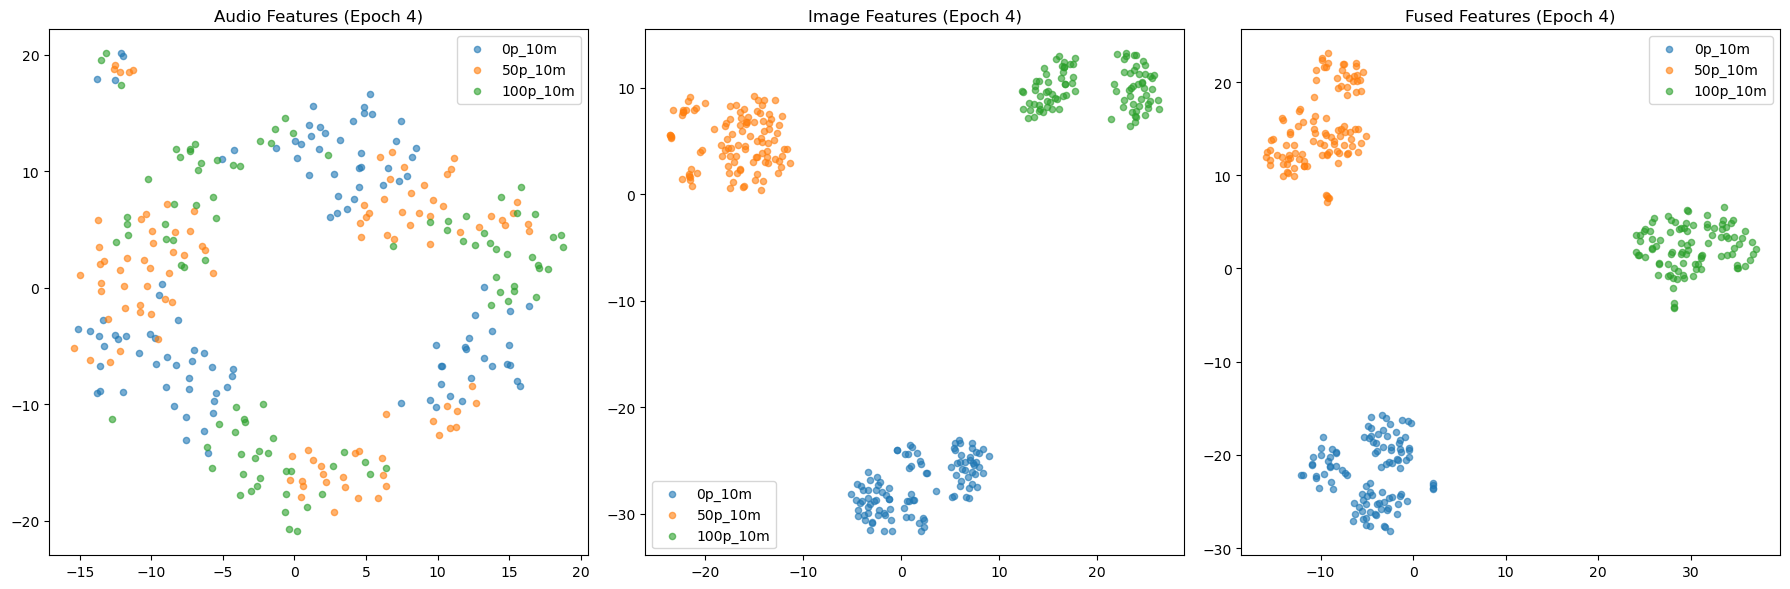

 27%|██▋       | 4/15 [00:29<01:19,  7.23s/it]

Epoch [5/15] Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.0005, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1522048bcc20>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1522048bc5e0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

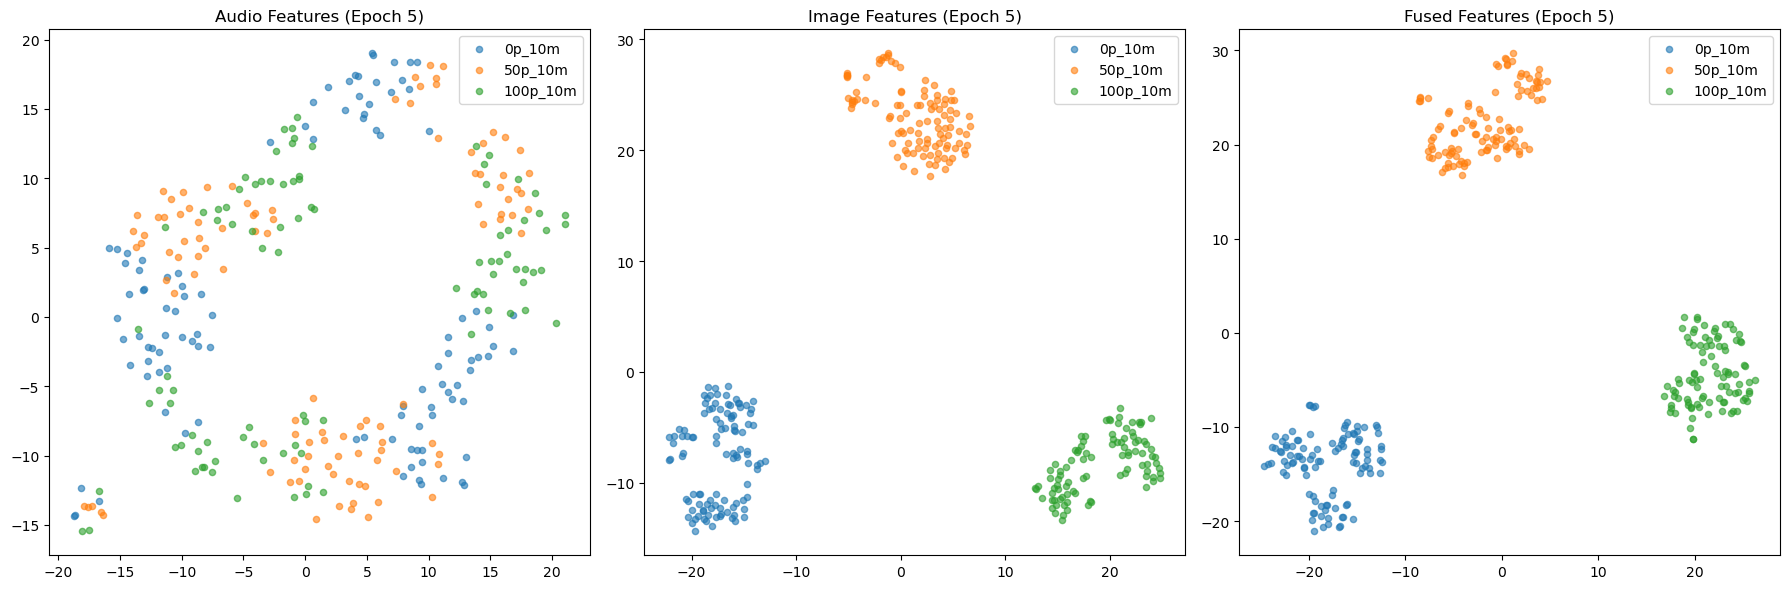

 33%|███▎      | 5/15 [00:36<01:12,  7.21s/it]

Epoch [6/15] Train Loss: 0.0046, Train Acc: 1.0000, Val Loss: 0.0007, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f43afe20>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f43af2e0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

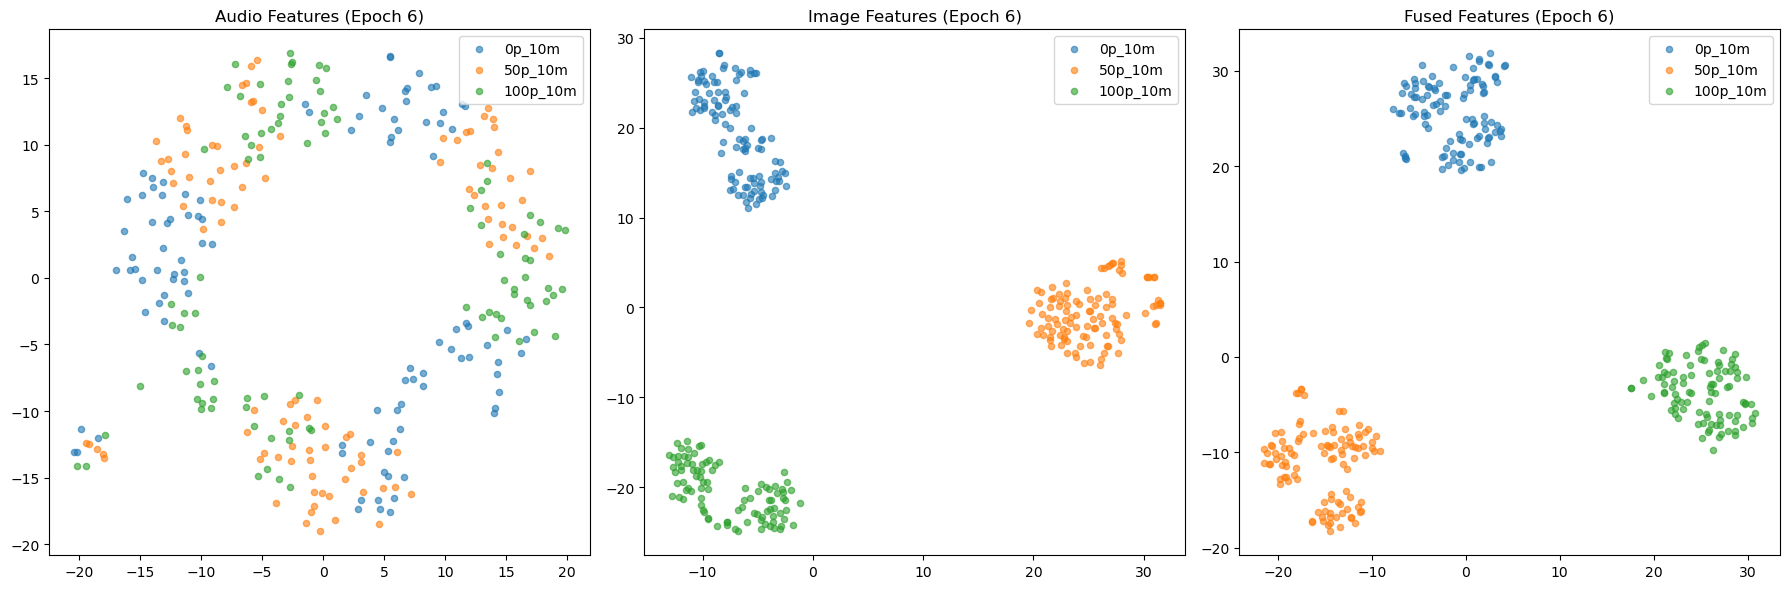

 40%|████      | 6/15 [00:43<01:04,  7.12s/it]

Epoch [7/15] Train Loss: 0.0069, Train Acc: 1.0000, Val Loss: 0.0022, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f43c1300>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220f7325c0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

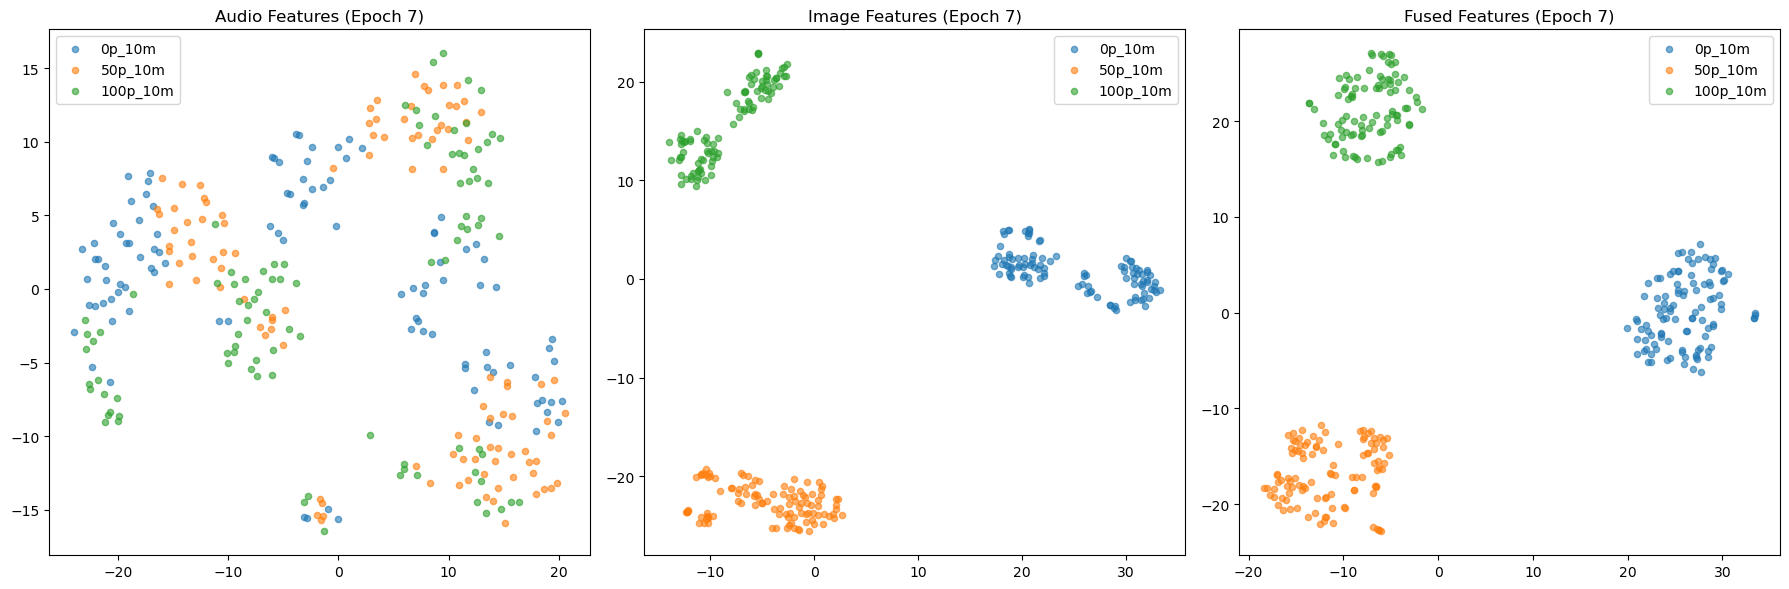

 47%|████▋     | 7/15 [00:50<00:57,  7.15s/it]

Epoch [8/15] Train Loss: 0.0138, Train Acc: 0.9983, Val Loss: 0.2281, Val Acc: 0.9085


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f41c3ec0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x152204818b80>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

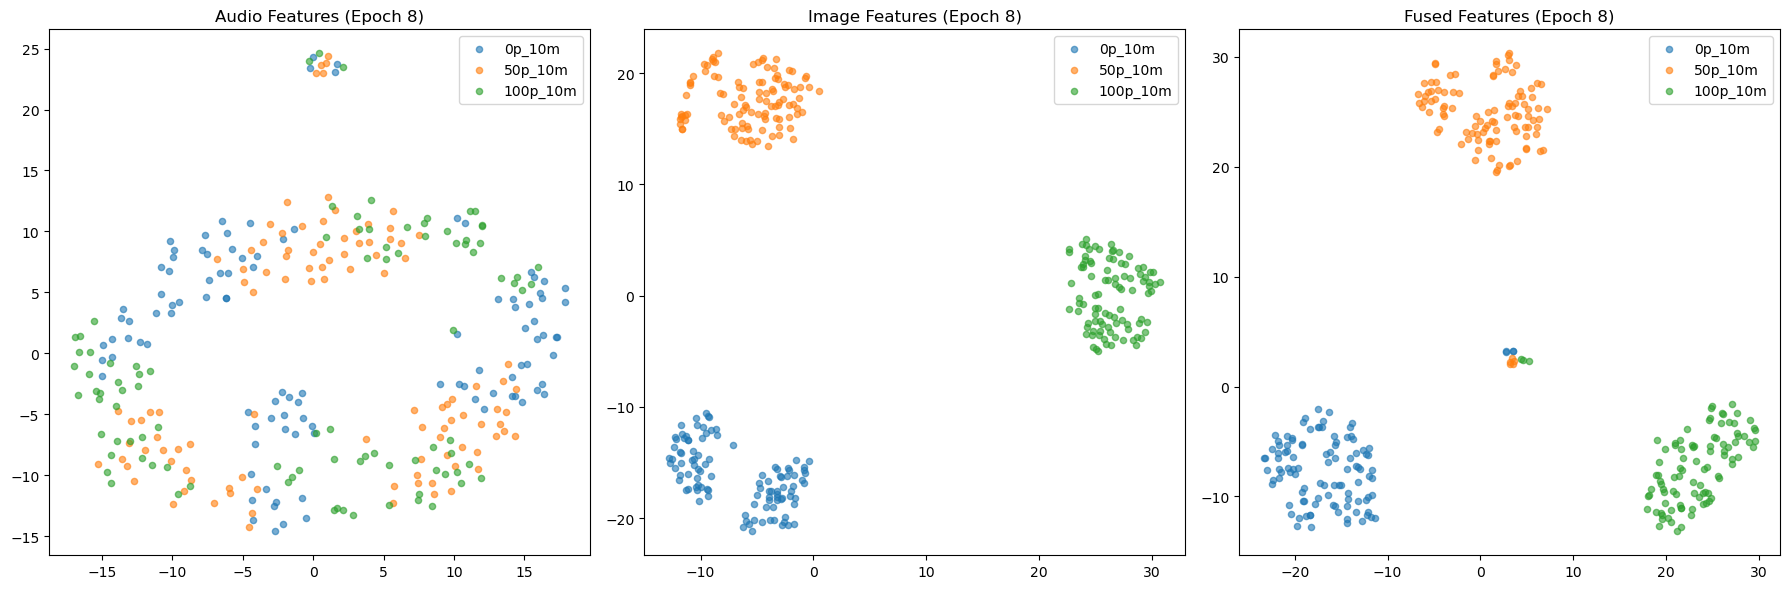

 53%|█████▎    | 8/15 [01:00<00:56,  8.07s/it]

Epoch [9/15] Train Loss: 0.0189, Train Acc: 0.9949, Val Loss: 0.0126, Val Acc: 0.9967


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f41dc540>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f41ddf80>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

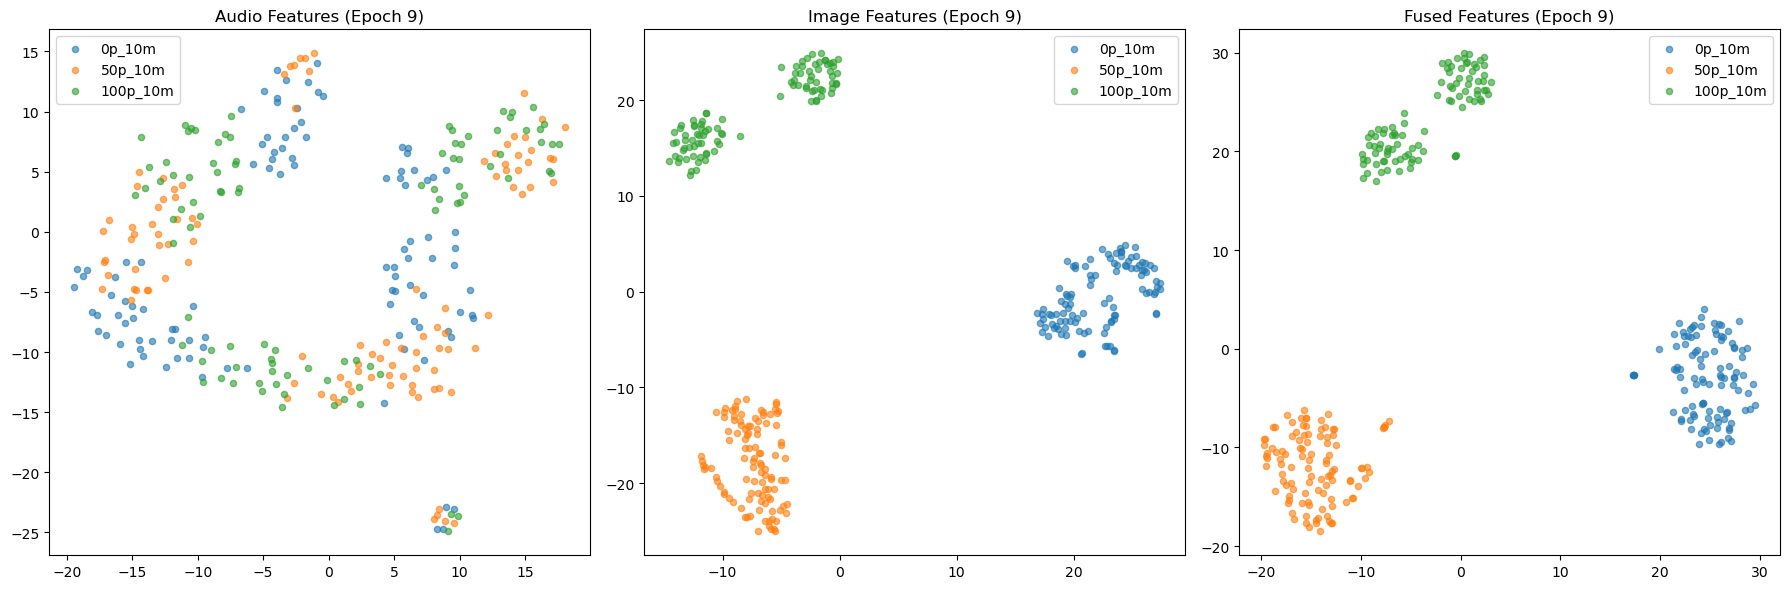

 60%|██████    | 9/15 [01:07<00:47,  7.84s/it]

Epoch [10/15] Train Loss: 0.0174, Train Acc: 0.9983, Val Loss: 0.0316, Val Acc: 0.9902


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220d22c400>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220d22f560>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

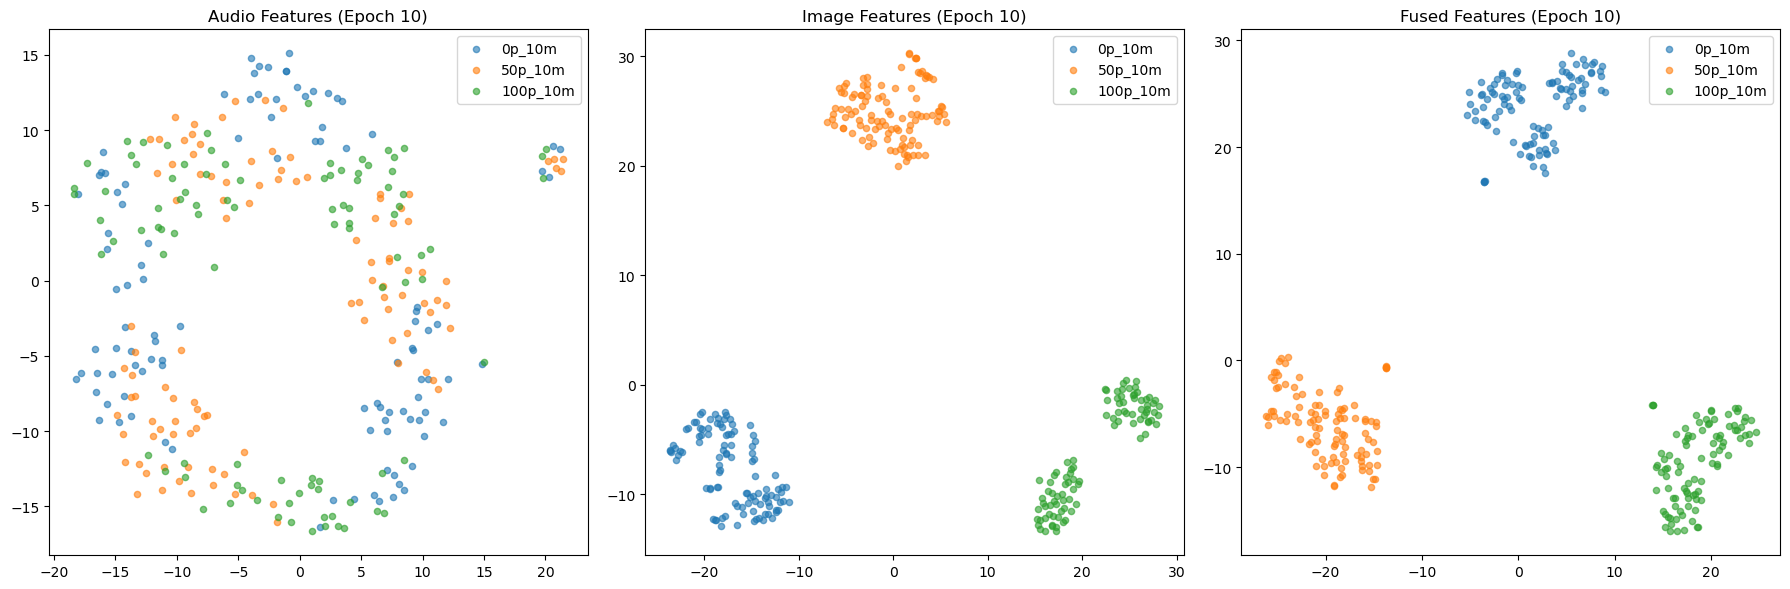

 67%|██████▋   | 10/15 [01:15<00:38,  7.63s/it]

Epoch [11/15] Train Loss: 0.0026, Train Acc: 1.0000, Val Loss: 0.0015, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220d0aade0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220d0abd80>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

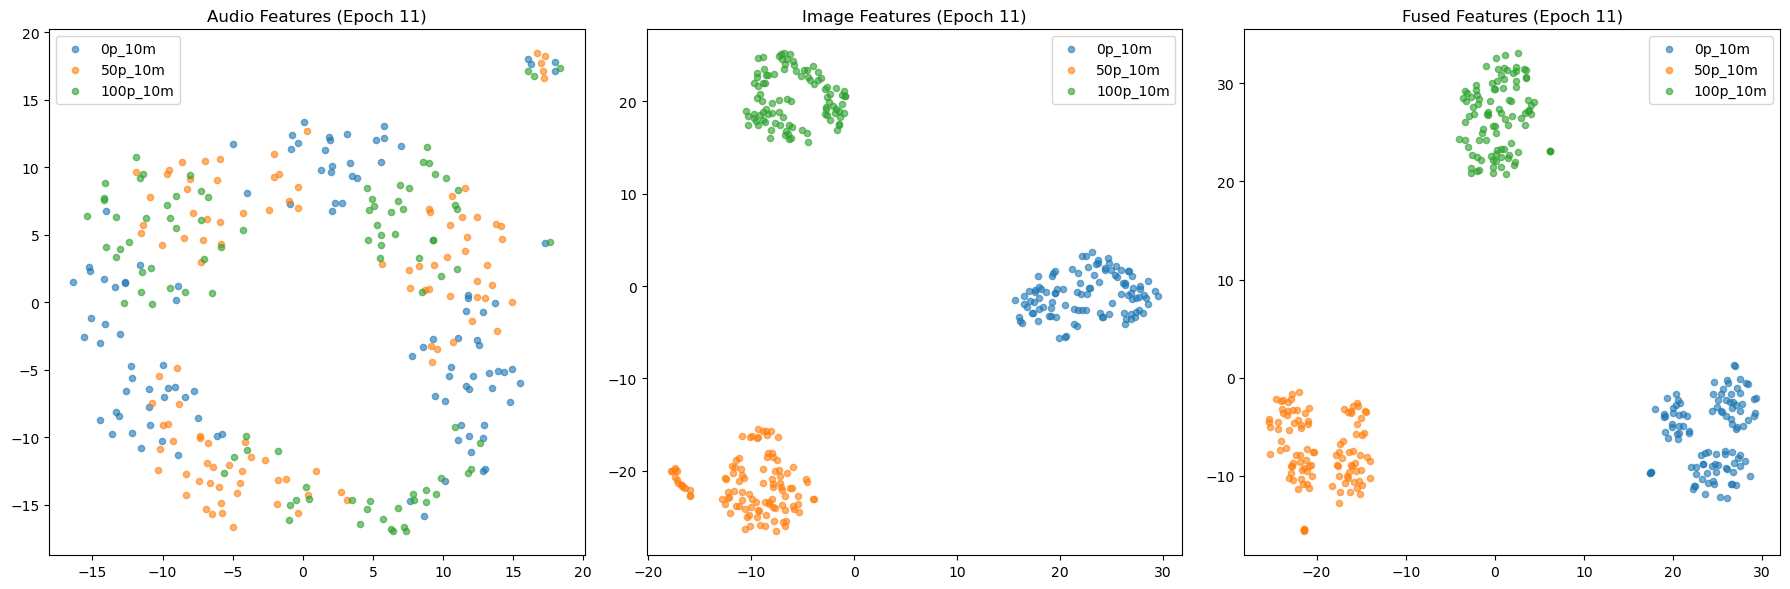

 73%|███████▎  | 11/15 [01:23<00:31,  7.96s/it]

Epoch [12/15] Train Loss: 0.0077, Train Acc: 0.9983, Val Loss: 0.0606, Val Acc: 0.9771


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220c906020>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220f87c860>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

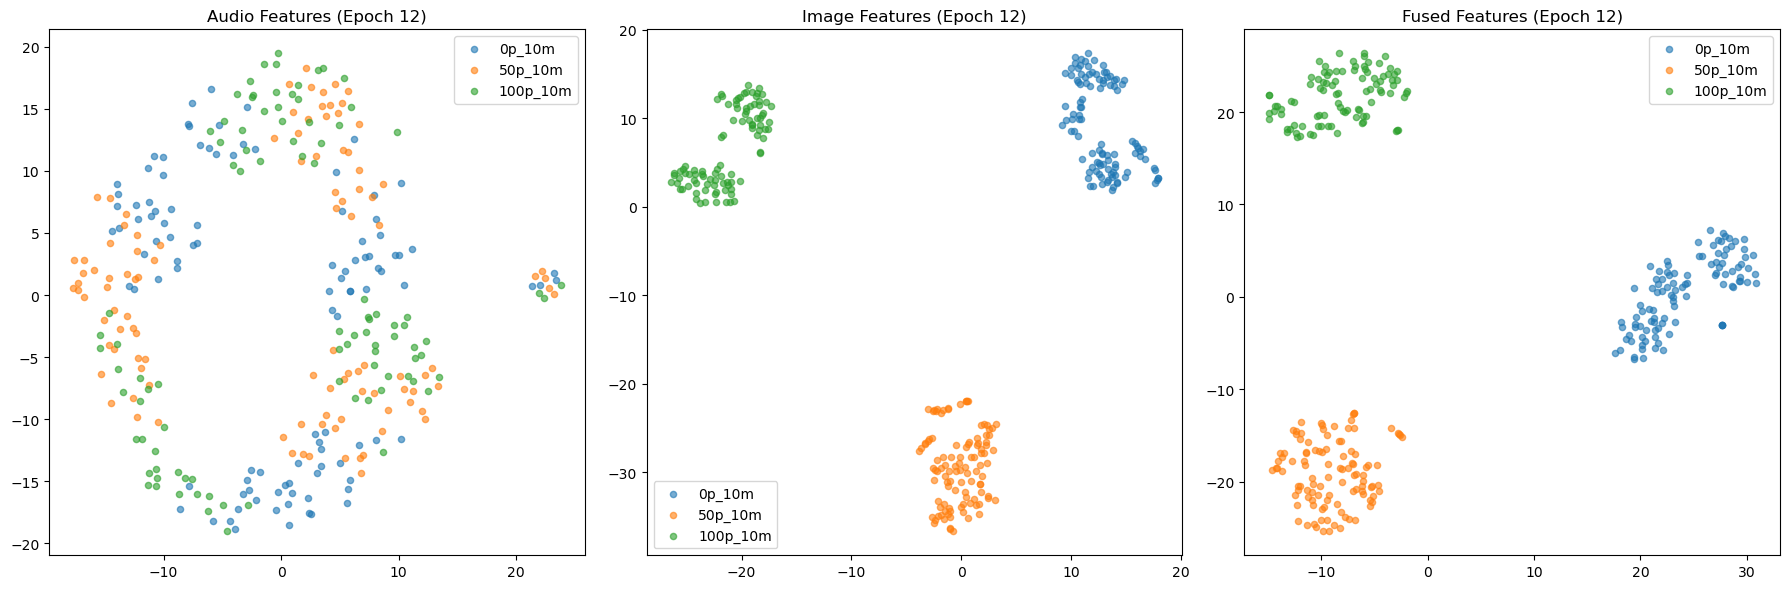

 80%|████████  | 12/15 [01:31<00:23,  7.87s/it]

Epoch [13/15] Train Loss: 0.0022, Train Acc: 1.0000, Val Loss: 0.0002, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220f82a700>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220f82a700>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

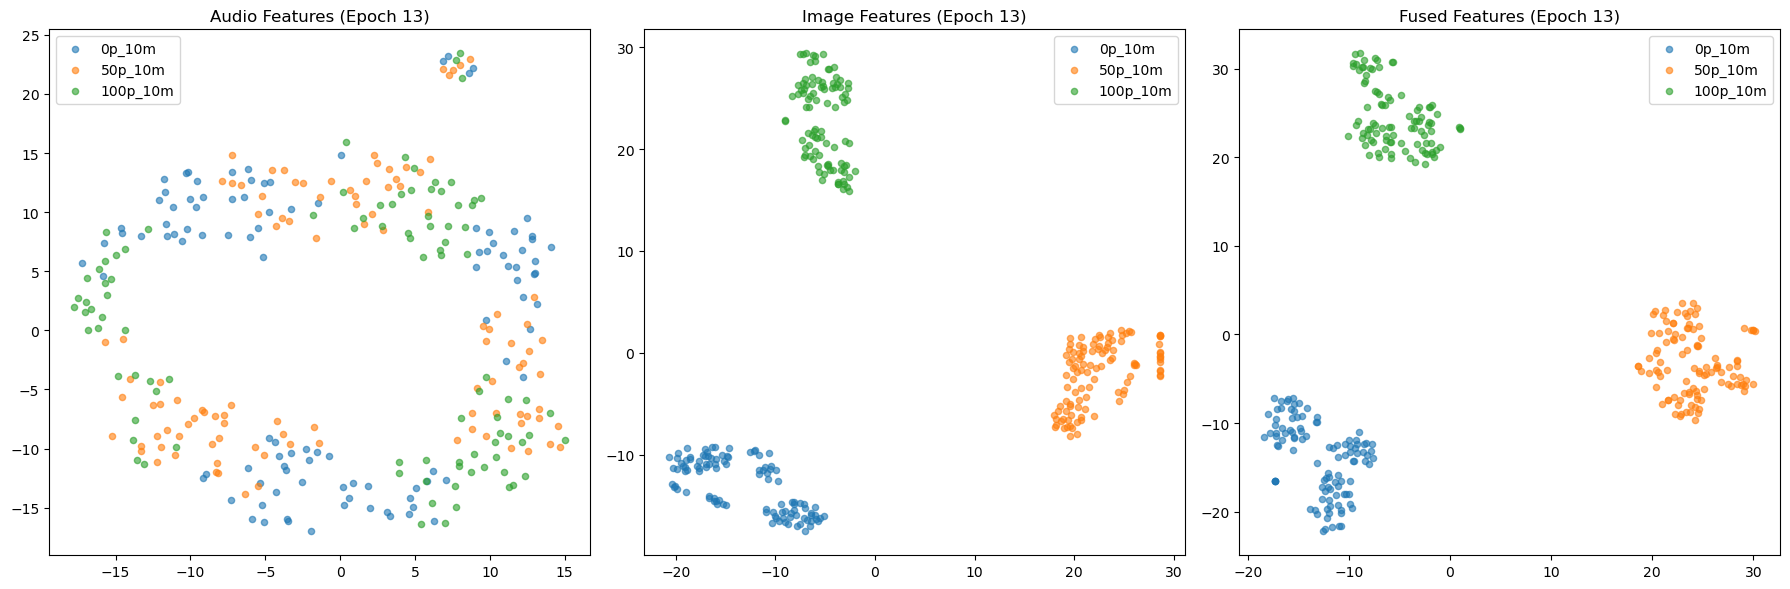

 87%|████████▋ | 13/15 [01:41<00:16,  8.49s/it]

Epoch [14/15] Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0002, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f40ec720>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f40ec7c0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

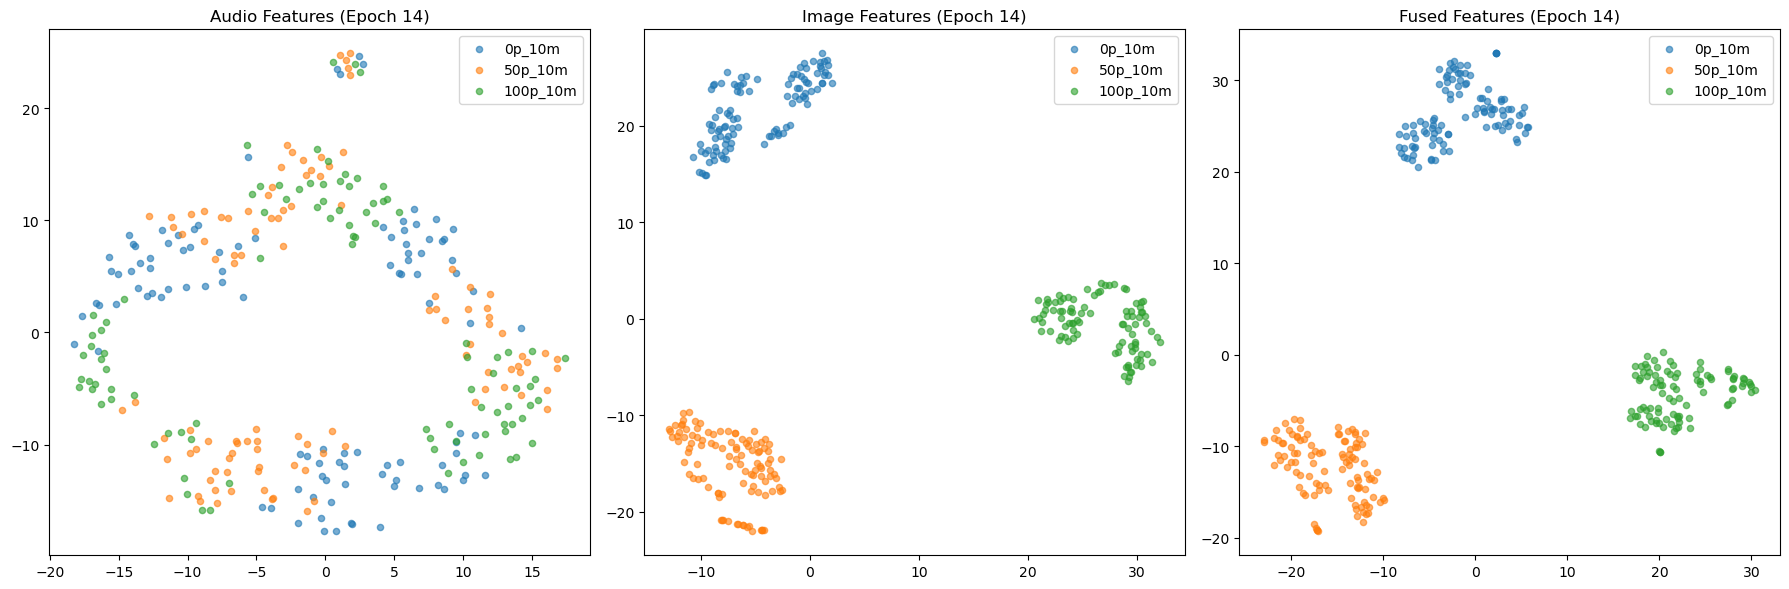

 93%|█████████▎| 14/15 [01:49<00:08,  8.34s/it]

Epoch [15/15] Train Loss: 0.0026, Train Acc: 0.9983, Val Loss: 0.0011, Val Acc: 1.0000


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f42a6c00>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f42a6d40>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

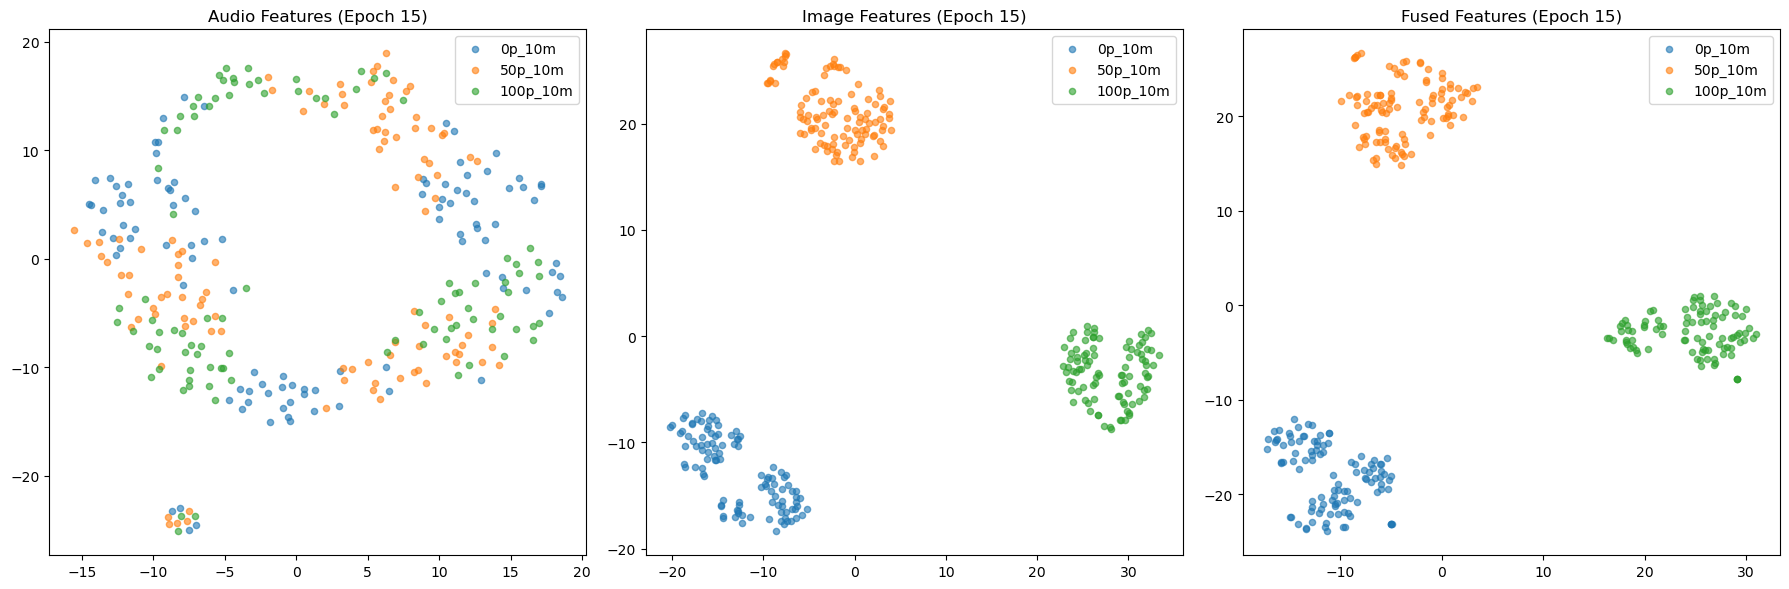

100%|██████████| 15/15 [01:59<00:00,  7.94s/it]


Visualizing features AFTER training...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f44abce0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 106, 0: 105, 2: 95})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1521f44abe20>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

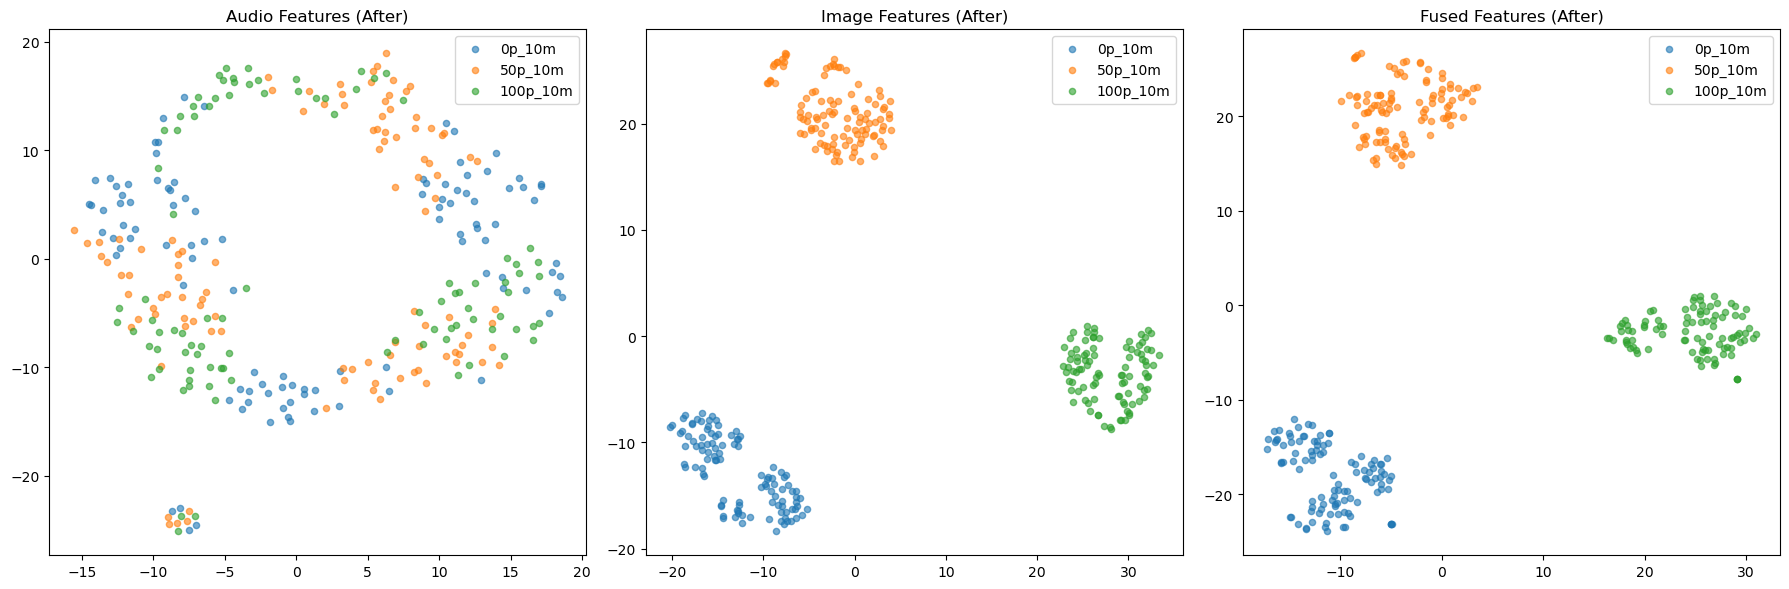


Visualizing test set features...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15220c9053a0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Label counts: Counter({1: 5, 0: 3, 2: 1})


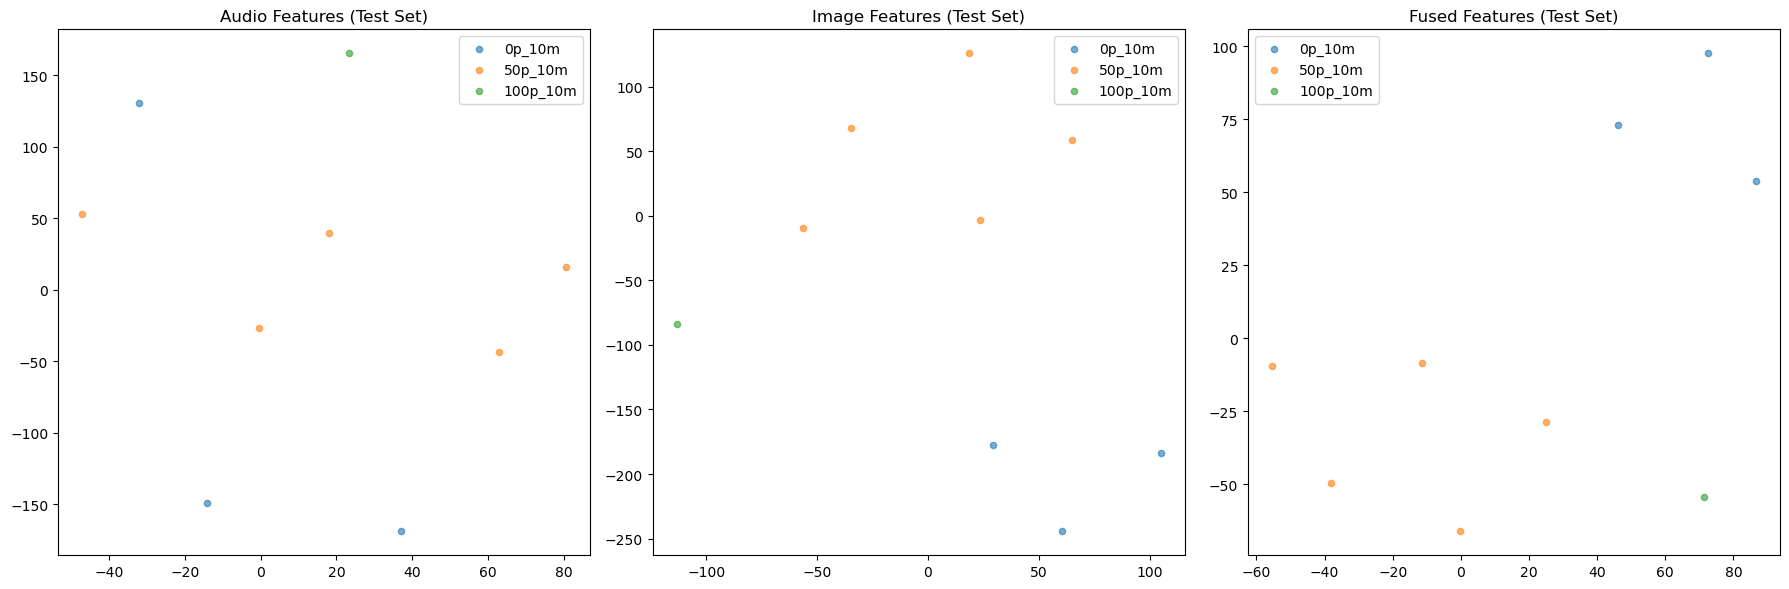


Evaluating on test set...
Test Loss: 0.0024, Test Acc: 1.0000 (n=9)


ValueError: perplexity must be less than n_samples

In [60]:
# MAIN
if __name__ == "__main__":
    # prepare_dataset_from_videos(RAW_VIDEOS)

    model, test_loader, criterion = train()

    if model is None:
        raise RuntimeError("Training failed or dataset was empty.")
      

    test_loss, test_acc, test_n = test(model, test_loader, criterion, DEVICE)
    
    visualize_test_correctness(model, test_loader)


    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), os.path.join("models", "multimodal_model_battery_v3.pth"))
    print("Training complete and model saved!")
    
    y_true, y_pred = collect_preds_from_loader(model, test_loader, DEVICE)

    plot_confusion_matrix(y_true, y_pred, LABELS)  
    plot_class_accuracy(y_true, y_pred, LABELS)
    visualize_test_correctness(model, test_loader)
